In [1]:
# Import libraries

from itertools import product
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

import pymysql
import pymongo
import sqlalchemy
from sqlalchemy import create_engine

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-poster')

from scipy import stats
import statsmodels.api as sm

In [2]:
#Load data
from config import mongoConn, remote_db_endpoint, remote_db_name, remote_db_port, remote_db_user, remote_db_pwd

pymysql.install_as_MySQLdb()
engine = create_engine(f"mysql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}/{remote_db_name}")
conn = engine.connect()

query = '''

    SELECT 
        RecordDate,
        OpenPrice,
        High,
        Low,
        ClosingPrice,
        AdjClose,
        Volume,
        c.CoinName,
        cph.TokenName
    FROM
        CoinPriceHistory cph
    INNER JOIN Coins c
        ON cph.CoinID = c.CoinID
    ORDER BY
        RecordDate

'''

coin_raw = pd.read_sql(query, conn)

In [3]:
query = '''
    SELECT CoinName FROM Coins
'''
coin_names = pd.read_sql(query,conn)

In [22]:
coin_of_interest = input("Which Crypto do you want to predict?")

Which Crypto do you want to predict?Bitcoin Gold


In [23]:
if coin_names[coin_names['CoinName']==coin_of_interest].any().bool():
    print("We got your coin!")
else:
    print('We NO got your coin')

We got your coin!


In [24]:
# Clean data
coin_history = coin_raw[coin_raw['CoinName']==coin_of_interest]
coin_history['RecordDate'] = pd.to_datetime(coin_history['RecordDate'], errors='coerce')
coin_history.rename(columns={'RecordDate':'Timestamp','OpenPrice':'Open', 'ClosingPrice':'Close'}, inplace=True)
coin_history.set_index('Timestamp', inplace=True)
coin_history.drop(['AdjClose', 'Volume', 'CoinName', 'TokenName'], axis=1, inplace=True)
coin_history = coin_history[coin_history['Close']!=0]

In [25]:
coin_history.head()

,Open,High,Low,Close
Timestamp,,,,
2017-11-01,157.02,509.81,105.79,304.64
2017-12-01,304.34,488.57,195.87,261.72
2018-01-01,261.63,382.89,146.50,156.96
2018-02-01,156.89,168.52,72.12,113.18
2018-03-01,113.07,118.99,43.18,44.34


In [26]:
# Box-Cox Transformations
coin_history['Box'], lmbda = stats.boxcox(coin_history.Close)

# Seasonal differentiation
coin_history['BoxDiff'] = coin_history.Box - coin_history.Box.shift(12)

# Regular differentiation
coin_history['BoxDiff2'] = coin_history.BoxDiff - coin_history.BoxDiff.shift(1)

In [27]:
# Save input
coin_history.to_excel(r'cryptkeeper_input.xlsx',index = True)

In [28]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [29]:
# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(coin_history.Box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except:
        print('Data cannot be conditioned for ARIMA model.  Sorry!')
        
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Data cannot be conditioned for ARIMA model.  Sorry!


In [12]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [13]:
# Prediction
coin_history_with_predictions = coin_history[['Close']]
coin_history_with_predictions['Forecast'] = invboxcox(best_model.predict(start = 0, end=(len(coin_history_with_predictions)-1)), lmbda)

In [14]:
prediction_dates = [datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021, 6, 30), 
             datetime(2021, 7, 31), datetime(2021, 8, 31), datetime(2021, 9, 30), datetime(2021, 10, 31),
             datetime(2021, 11, 30), datetime(2021, 12, 31)]
future = pd.DataFrame(index=prediction_dates, columns= coin_history.columns)
future['Forecast'] = invboxcox(best_model.forecast(steps=len(future)), lmbda).tolist()

In [15]:
coin_history_with_predictions = pd.concat([coin_history_with_predictions, future])
coin_history_with_predictions['Coin'] = coin_of_interest

In [16]:
graph = coin_history_with_predictions.reset_index().rename(columns={'index':'Date'})
graph2 = graph[['Coin','Date', 'Close', 'Forecast']]
graph2.tail(30)

,Coin,Date,Close,Forecast
39,Ethereum,2019-06-30,218.65,207.385411
40,Ethereum,2019-07-31,172.47,306.167812
41,Ethereum,2019-08-31,179.87,123.820590
42,Ethereum,2019-09-30,183.97,158.720853
43,Ethereum,2019-11-01,152.54,221.842018
44,Ethereum,2019-12-01,129.61,208.606392
45,Ethereum,2020-01-01,180.16,172.520524
46,Ethereum,2020-02-01,219.85,126.441961
47,Ethereum,2020-03-01,133.59,145.897707
48,Ethereum,2020-03-31,207.60,226.540493


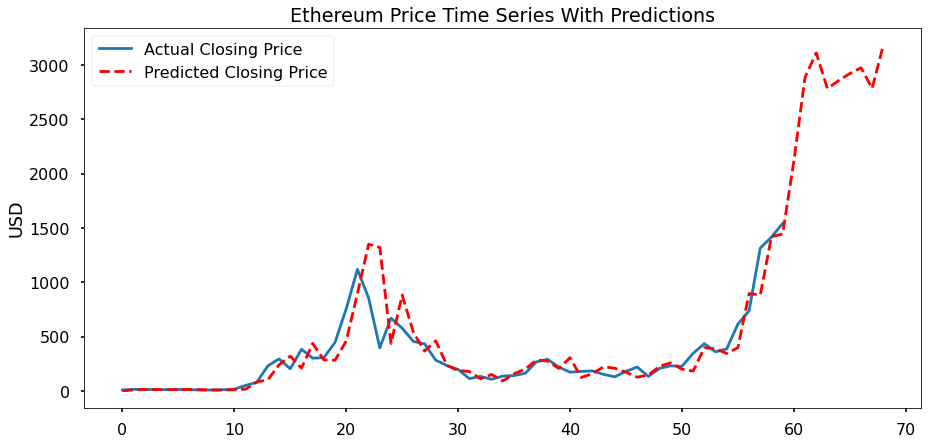

In [17]:
plt.figure(figsize=(15,7))
graph2.Close.plot(label="Actual Closing Price")
graph2.Forecast.plot(color='r', ls='--', label='Predicted Closing Price')
plt.legend()
plt.title(f'{coin_of_interest} Price Time Series With Predictions')
plt.ylabel('USD')
plt.show()

In [18]:
future['Forecast']

2021-04-30    2115.120527
2021-05-31    2886.411840
2021-06-30    3112.528667
2021-07-31    2784.479479
2021-08-31    2856.566518
2021-09-30    2921.680380
2021-10-31    2975.138282
2021-11-30    2785.707216
2021-12-31    3185.916871
Name: Forecast, dtype: float64

In [19]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
27  (1, 1, 1, 1)  192.643240
3   (0, 0, 1, 1)  192.918265
45  (2, 1, 1, 1)  193.768084
5   (0, 0, 2, 1)  193.888011
21  (1, 0, 1, 1)  194.293274
                                     SARIMAX Results                                      
Dep. Variable:                                Box   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -91.322
Date:                            Mon, 15 Mar 2021   AIC                            192.643
Time:                                    18:09:24   BIC                            201.894
Sample:                                         0   HQIC                           196.124
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------